# Agglomerative Clustering – Wine Quality (Vin rouge)

Ce notebook applique **Agglomerative Clustering** selon le cahier des charges :
- Construire une hiérarchie des vins
- Visualiser un dendrogramme
- Évaluer avec silhouette score
- Suivi avec MLflow

## 1. Imports et configuration

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Trouver la racine du projet (dossier contenant src/preprocessing.py)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project (File > Open Folder) puis relancez.")
from preprocessing import load_data, clean_data, scale_features
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import mlflow
import mlflow.sklearn

mlflow.set_experiment("wine-quality-agglomerative")

<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/clustering/mlruns/2', creation_time=1770927231001, experiment_id='2', last_update_time=1770927231001, lifecycle_stage='active', name='wine-quality-agglomerative', tags={}>

## 2. Chargement et preprocessing

In [8]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

X = df.drop(columns=["quality"])
y = df["quality"]

X_scaled, scaler = scale_features(X)

# PCA 2D pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Dataset shape: {df.shape}")

Dataset shape: (1359, 12)


## 3. Agglomerative Clustering

Silhouette score (Agglomerative, k=4): 0.343


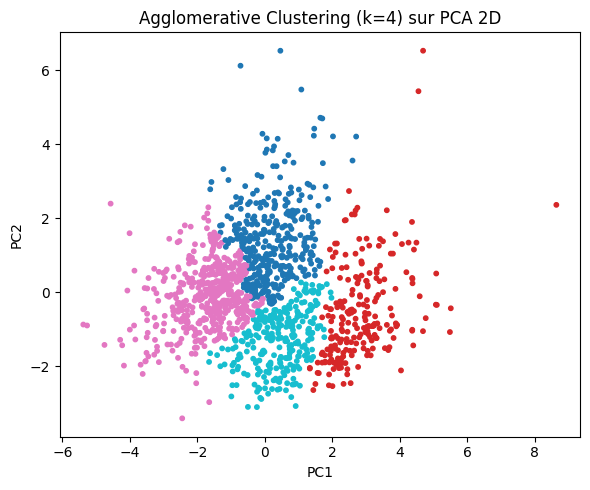

In [9]:
# Agglomerative Clustering avec k=4
n_clusters = 4
agg = AgglomerativeClustering(n_clusters=n_clusters)
labels = agg.fit_predict(X_pca)

sil = silhouette_score(X_pca, labels)
print(f"Silhouette score (Agglomerative, k={n_clusters}): {sil:.3f}")

# Visualisation des clusters
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=10)
plt.title(f"Agglomerative Clustering (k={n_clusters}) sur PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("agg_clusters.png")
plt.show()

## 4. Dendrogramme (selon cahier des charges)

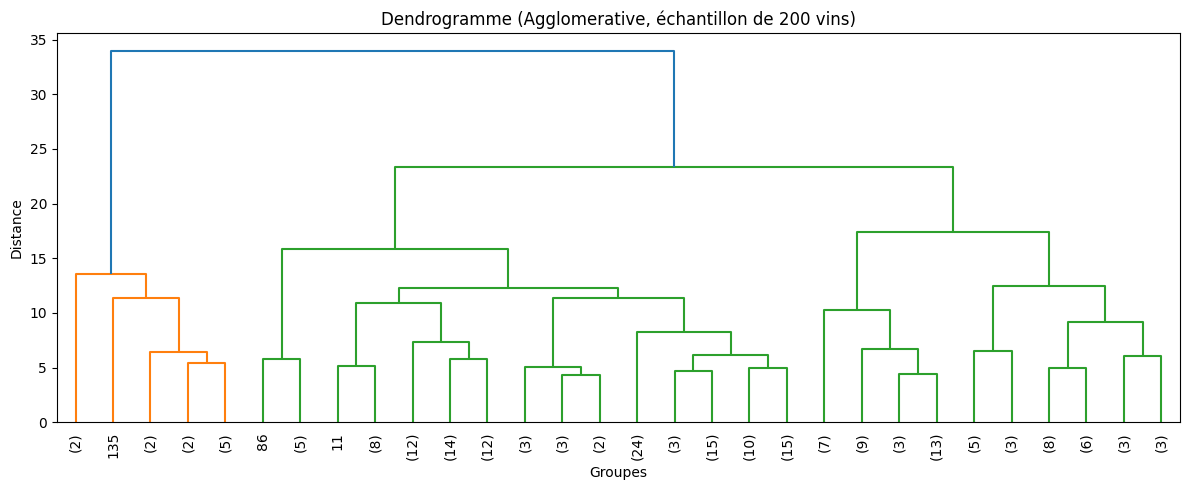

In [10]:
# Dendrogramme sur un sous-échantillon de 200 points pour lisibilité
X_sample = X_scaled[:200]
Z = linkage(X_sample, method="ward")

plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90.)
plt.title("Dendrogramme (Agglomerative, échantillon de 200 vins)")
plt.xlabel("Groupes")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig("dendrogram.png")
plt.show()

## 5. Comparaison avec les catégories de qualité

Répartition qualité par cluster:
             mean       std  count
cluster                           
0        5.320442  0.588036    362
1        5.848889  0.857900    225
2        5.485944  0.815348    498
3        6.087591  0.829621    274


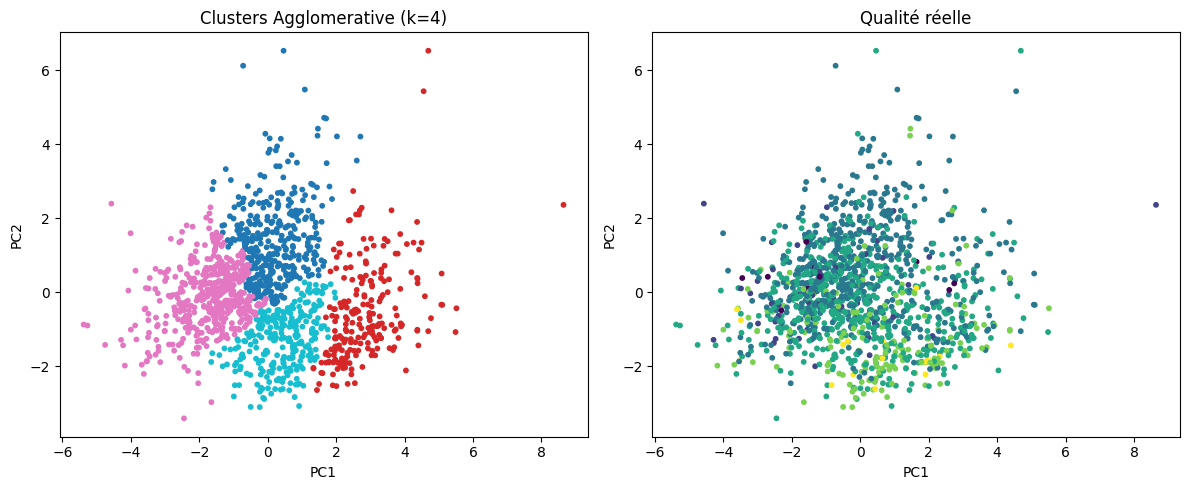

In [11]:
# Comparaison clusters vs qualité réelle
comparison_df = pd.DataFrame({
    'cluster': labels,
    'quality': y
})

print("Répartition qualité par cluster:")
print(comparison_df.groupby('cluster')['quality'].agg(['mean', 'std', 'count']))

# Visualisation clusters vs quality
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=10)
axes[0].set_title(f"Clusters Agglomerative (k={n_clusters})")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=10)
axes[1].set_title("Qualité réelle")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.savefig("agg_comparison.png")
_cwd = os.getcwd()
_project_root = os.path.dirname(_cwd) if os.path.basename(_cwd) in ('classification','clustering','reduction') else _cwd
_fig_dir = os.path.join(_project_root, 'rapport', 'figures')
os.makedirs(_fig_dir, exist_ok=True)
plt.savefig(os.path.join(_fig_dir, 'agg_comparison.png'))
plt.show()

## 6. MLflow tracking

In [12]:
with mlflow.start_run(run_name=f"Agglomerative_k{n_clusters}"):
    mlflow.log_param("n_clusters", n_clusters)
    mlflow.log_param("linkage_method", "ward")
    mlflow.log_metric("silhouette_score", float(sil))
    mlflow.log_artifact("agg_clusters.png")
    mlflow.log_artifact("dendrogram.png")
    mlflow.log_artifact("agg_comparison.png")
    mlflow.sklearn.log_model(agg, "agglomerative_model")
    print("MLflow run terminé")

2026/02/14 17:35:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
2026/02/14 17:35:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


MLflow run terminé
